# Dataset

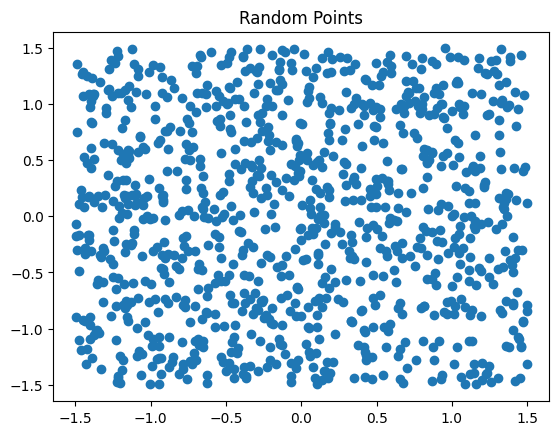

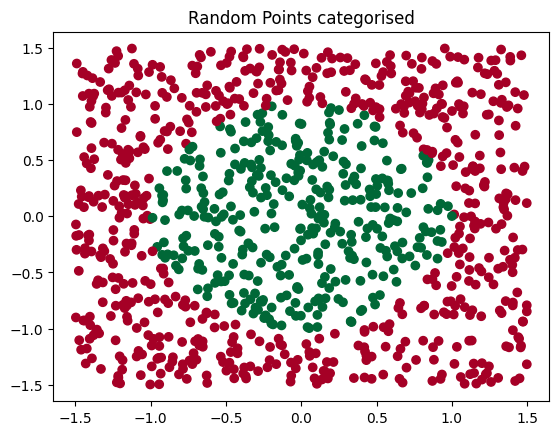

In [ ]:
#Scattered points
import numpy as np
import matplotlib.pyplot as plt

def generate_data(distribution='circle', n_samples=1000):
    if distribution == 'circle':
        X = np.random.uniform(low=-1.5, high=1.5, size=(n_samples,3))
        X[:, 2] = ((X[:, 0]**2 + X[:, 1]**2) < 1).astype(int)
    elif distribution == 'square':
        X = np.random.uniform(low=-1.5, high=1.5, size=(n_samples,3))
        X[:, 2] = ((abs(X[:, 0])<1) & (abs(X[:, 1])<1)).astype(int)
    elif distribution == 'ellipse':
        X = np.random.uniform(low=-5, high=5, size=(n_samples,3))
        X[:, 2] = (((X[:, 0]**2)/4 + (X[:, 1]**2)/25) < 1).astype(int)
    return X

#regular plot
X = generate_data("circle")
plt.scatter(X[:, 0], X[:, 1])
plt.title('Random Points')
plt.show()

#categorised plot
plt.scatter(X[:, 0], X[:, 1], c=X[:, 2], cmap='RdYlGn')
plt.title('Random Points categorised')
plt.show()

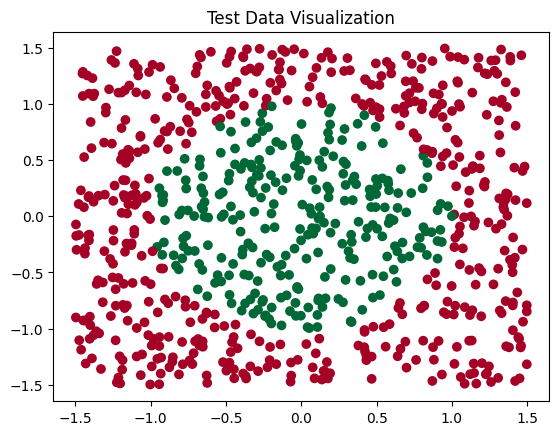

In [ ]:
from sklearn.model_selection import train_test_split

# Split into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X[:, 0:2], X[:, 2],test_size=0.2, random_state=42)

plt.scatter(X_train[:,0], X_train[:,1],c=y_train,cmap='RdYlGn')
plt.title('Test Data Visualization')
plt.show()

# 3 Layer MLP

In [ ]:
#define model
def init_three_layer_model(input_size, hidden_size1, hidden_size2, output_size):
    model = {}
    model['W1'] = 0.5 * np.random.randn(input_size, hidden_size1)
    model['b1'] = np.zeros(hidden_size1)
    model['W2'] = 0.5 * np.random.randn(hidden_size1, hidden_size2)
    model['b2'] = np.zeros(hidden_size2)
    model['W3'] = 0.5 * np.random.randn(hidden_size2, output_size)
    model['b3'] = np.zeros(output_size)
    return model

def relu(x):
    return np.maximum(0, x)

def softmax(scores):
    scores -= np.max(scores, axis=1, keepdims=True)
    exp_scores = np.exp(scores)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


def three_layer_net(X, model, y, reg=0.1):
    W1, b1 = model['W1'], model['b1']
    W2, b2 = model['W2'], model['b2']
    W3, b3 = model['W3'], model['b3']

    # Forward pass
    N = X.shape[0]
    z1 = X.dot(W1) + b1
    a1 = relu(z1)
    z2 = a1.dot(W2) + b2
    a2 = relu(z2)
    scores = a2.dot(W3) + b3
    probs = softmax(scores)

    # Loss
    logprobs = -np.log(probs[range(N),y.astype(int)])
    data_loss = np.mean(logprobs)
    reg_loss = 0.5 * reg * (np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**2))
    loss = data_loss + reg_loss

    # Backward pass
    grads = {}
    dscores = probs
    #backprop of softmax and log
    dscores[range(N), y.astype(int)] -= 1
    dscores /= N

    grads['W3'] = a2.T.dot(dscores) + reg * W3
    grads['b3'] = np.sum(dscores, axis=0)

    da2 = dscores.dot(W3.T)
    dz2 = da2 * (z2 > 0)  # relu backward

    grads['W2'] = a1.T.dot(dz2) + reg * W2
    grads['b2'] = np.sum(dz2, axis=0)

    da1 = dz2.dot(W2.T)
    dz1 = da1 * (z1 > 0)  # relu backward

    grads['W1'] = X.T.dot(dz1) + reg * W1
    grads['b1'] = np.sum(dz1, axis=0)

    return loss, grads

In [ ]:
#initialise and train model on test data
input_size = 2
hidden_size1 = 10
hidden_size2 = 6
output_size = 2
step_size= 0.01
def trainMLP(model):
  for epoch in range(4000):
    loss, grads = three_layer_net(X_train, model, y_train, reg=0)
    for param in model:
      model[param]+= -step_size*grads[param]
    print("Loss:", loss)

In [ ]:
def evaluate_mlp_model(X_test, y_test):
    model = init_three_layer_model(input_size, hidden_size1, hidden_size2, output_size)
    trainMLP(model)
    W1, b1 = model['W1'], model['b1']
    W2, b2 = model['W2'], model['b2']
    W3, b3 = model['W3'], model['b3']
    y_test = y_test.astype(int)

    # Forward pass
    z1 = X_test.dot(W1) + b1
    a1 = relu(z1)
    z2 = a1.dot(W2) + b2
    a2 = relu(z2)
    scores = a2.dot(W3) + b3

    # Predicted class is the index with max prob
    preds = np.argmax(scores, axis=1)

    # Accuracy
    accuracy = np.mean(preds == y_test)
    print("Predictions:", preds)
    print("Actual     :", y_test)
    print(f"Accuracy: {accuracy}")

    #test data classification plot
    fig, ax = plt.subplots()
    ax.scatter(X_test[:, 0], X_test[:, 1], c=preds, cmap='RdYlGn')
    ax.set_title(f'Predicted Classes - Accuracy : {accuracy:.2f}')

    return fig, f"Accuracy: {accuracy:.4f}"

# evaluate_mlp_model(X_test, y_test)

# Transformer

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=2, d_model=64, num_heads=4, num_classes=2):
        super().__init__()

        # Project input to d_model
        self.input_proj = nn.Linear(input_dim, d_model)

        # Transformer encoder (treating each input as a sequence of length 1)
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=num_heads, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)

        # Classifier
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: (1, 1, input_dim)
        x = self.input_proj(x)            # -> (1, 1, d_model)
        encoded = self.encoder(x)         # -> (1, 1, d_model)
        return self.classifier(encoded.squeeze(1))  # -> (1, num_classes)

# Initialize model, optimizer, loss
modeltran = TransformerClassifier()
optimizertran = torch.optim.Adam(modeltran.parameters(), lr=1e-3)
criteriontran = nn.CrossEntropyLoss()

# Prepare data
X_train = np.array(X_train)  # (800, 2)
y_train = np.array(y_train)  # (800,)
inputs = torch.tensor(X_train).float()
labels = torch.tensor(y_train).long()

# Training loop
def trainTransformer():
  # global model, optimizer
  # model = TransformerClassifier()
  # optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  num_epochs = 5
  for epoch in range(num_epochs):
      total_loss = 0
      correct = 0
      for i in range(len(inputs)):
          x = inputs[i].unsqueeze(0).unsqueeze(0)   # -> (1, 1, 2)
          y = labels[i].unsqueeze(0)                # -> (1,)

          logits = modeltran(x)                         # -> (1, 2)
          loss = criteriontran(logits, y)

          optimizertran.zero_grad()
          loss.backward()
          optimizertran.step()

          total_loss += loss.item()
          pred = torch.argmax(logits, dim=1)
          correct += (pred == y).sum().item()

      acc = correct / len(inputs)
      print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_tf_model(X_test, y_test):
    trainTransformer()
    modeltran.eval()  # Set model to evaluation mode

    # Convert inputs to torch tensors
    inputs = torch.tensor(X_test).float()
    labels = torch.tensor(y_test).long()

    preds = []
    with torch.no_grad():
        for i in range(len(inputs)):
            x = inputs[i].unsqueeze(0).unsqueeze(0)  # (1, 1, 2)
            logits = modeltran(x)  # (1, 2)
            pred = torch.argmax(logits, dim=1).item()
            preds.append(pred)

    preds = np.array(preds)
    accuracy = np.mean(preds == y_test)

    print("Predictions:", preds)
    print("Actual     :", y_test)
    print(f"Accuracy: {accuracy:.4f}")

    # Plot
    fig, ax = plt.subplots()
    ax.scatter(X_test[:, 0], X_test[:, 1], c=preds, cmap='RdYlGn')
    ax.set_title(f'Predicted Classes - Accuracy : {accuracy:.2f}')
    return fig, f"Accuracy: {accuracy:.4f}"

# evaluate_tf_model(X_test, y_test)

# Diffusion

In [ ]:
# Diffusion

# Training data
train = []
while len(train) < 1001:
    x, y = np.random.uniform(-1, 1, 2)
    if x**2 + y**2 < 1:
        train.append([x, y])
train=np.array(train)

# Model
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleDiffusionMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2 + 1, 64),  # input: x, y, timestep
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)       # output: predicted noise (delta_x, delta_y)
        )

    def forward(self, x, t):
        t = t.expand_as(x[:, :1])  # match shape of x : [100,1]
        inp = torch.cat([x, t], dim=1) # concatinate x with t, net becomes [100,3]
        return self.net(inp) #net function predicts noise in input

# Train
import torch.optim as optim
timesteps = 1000
beta1, beta2 = 1e-4, 0.02
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1) + beta1 #linearly increasing beta, as variance becomes beta2
a_t = 1 - b_t #linearly decreasing alpha as mean becomes beta1
ab_t = torch.cumprod(a_t, dim=0) #ab_t = multiplcation of a1,a2.....at

def perturb_input(x, t, noise):
    sqrt_ab = ab_t[t].sqrt().unsqueeze(1) # ab_t is [100]. sqrt_ab will be mean for t timestep. Unsqueeze : [100] -> [100,1]
    sqrt_one_minus_ab = (1 - ab_t[t]).sqrt().unsqueeze(1) #this is variance for timestep t
    return sqrt_ab * x + sqrt_one_minus_ab * noise #this fucntion takes x, a noiseless input point, and generates x_t, a noisy input at t timestep

model = SimpleDiffusionMLP()
optimizer = optim.Adam(model.parameters(), lr=1e-3) # used to reach min. loss faster, could also decay learning rate
train = torch.tensor(train, dtype=torch.float32)

def trainDiffusion():
  for epoch in range(2000):
      model.train() # model on training mode
      optimizer.zero_grad() # clears gradients from the previous backward pass

      #preturb input
      t = torch.randint(1, timesteps + 1, (train.shape[0],)) #create tensor of shape [100], one random timestep for each input
      noise = torch.randn_like(train) # gaussian noise to be added
      x_perturbed = perturb_input(train, t, noise)

      #predict original input using diffusion MLP model
      t_norm = t.float() / timesteps
      pred_noise = model(x_perturbed, t_norm.unsqueeze(1)) #python automaitcally calls the forward() method when u write model=...., use model().

      # find loss and backprop
      loss = F.mse_loss(pred_noise, noise)
      loss.backward()
      optimizer.step()

      if epoch % 20 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# trainDiffusion()

In [ ]:
import tempfile
import os
def helprunDf():
  def test(model, n_samples, frame_rate):
      trainDiffusion()
      model.eval()
      mean = torch.tensor([1.0, -2.0])  # shape (2,)
      std = torch.tensor([0.5, 1.5])    # shape (2,)
      x = torch.randn(n_samples, 2) * std + mean

      intermediate = []

      for i in reversed(range(1, timesteps + 1)): #reverse time
          t = torch.tensor([i / timesteps] * n_samples).unsqueeze(1)
          pred_noise = model(x, t)

          mean = (x - pred_noise * ((1 - a_t[i]) / (1 - ab_t[i]).sqrt())) / a_t[i].sqrt()
          if i > 1:
              noise = torch.randn_like(x)
              x = mean + (b_t[i].sqrt() * noise) #add extra noise to x after removing pred noise, beta increases with time
          else:
              x = mean
          if i % frame_rate == 0:
            intermediate.append(x.clone().detach().cpu().numpy())

      return x, intermediate


  # plot results
  import matplotlib.pyplot as plt
  import matplotlib.animation as animation
  from IPython.display import HTML

  samples, intermediate = test(model, 1000, 20)
  samples = samples.detach().cpu().numpy()
  #plt.figure(figsize=(5, 5))
  #plt.scatter(samples[:, 0], samples[:, 1], c='blue')
  #plt.title("Generated Samples")
  #plt.grid(True)
  #plt.show()
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.scatter(samples[:, 0], samples[:, 1], c='blue')
  ax.set_title("Generated Samples")

  # animate results
  def animate_samples(intermediate):
      fig, ax = plt.subplots(figsize=(5, 5))
      scat = ax.scatter(intermediate[0][:, 0], intermediate[0][:, 1], c='blue', s=10)
      ax.set_xlim(-5, 5)
      ax.set_ylim(-5, 5)
      ax.set_aspect('equal')

      def update(frame):
          scat.set_offsets(intermediate[frame])
          ax.set_title(f"Timestep {len(intermediate)-frame}")
          return scat,

      ani = animation.FuncAnimation(
          fig, update, frames=len(intermediate),
          interval=100
      )
      return ani

  ani = animate_samples(intermediate)
  #HTML(ani.to_jshtml())
  temp_dir = tempfile.gettempdir()
  gif_path = os.path.join(temp_dir, "diffusion.gif")
  ani.save(gif_path, writer="pillow")

  return fig, gif_path

# helprunDf()

# GAN

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Generate real data: points inside unit circle
def generate_real_samples(n):
    data = []
    while len(data) < n:
        x, y = np.random.uniform(-1, 1, 2) #generates 2 points between -1 and 1
        if x**2 + y**2 < 1:
            data.append([x, y])
    return torch.tensor(data, dtype=torch.float32)

# Generate noise for the generator
def generate_noise(n):
    return torch.randn(n, 2) #n samples, 2 dimensions per sample
    # mean = torch.tensor([1.0, -2.0])  # shape (2,)
    # std = torch.tensor([0.5, 1.5])    # shape (2,)
    # return torch.randn(n, 2) * std + mean

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Instantiate models
gen = Generator()
disc = Discriminator()

# Optimizers
gen_opt = optim.Adam(gen.parameters(), lr=1e-5)
disc_opt = optim.Adam(disc.parameters(), lr=1e-4)

# Loss function
criterion = nn.BCELoss() #binary cross entropy?

# Training loop
def trainGAN():
  epochs = 10000
  batch_size = 256
  for epoch in range(epochs):
      # === Train Discriminator ===
      disc_opt.zero_grad()

      real_data = generate_real_samples(batch_size)
      real_labels = torch.ones(batch_size, 1)

      noise = generate_noise(batch_size)
      fake_data = gen(noise).detach()  # detach so we don't backprop to generator
      fake_labels = torch.zeros(batch_size, 1)

      # Discriminator loss
      real_pred = disc(real_data)
      fake_pred = disc(fake_data)
      disc_loss = criterion(real_pred, real_labels) + criterion(fake_pred, fake_labels)
      disc_loss.backward()
      disc_opt.step()

      # === Train Generator ===
      gen_opt.zero_grad()
      noise = generate_noise(batch_size)
      fake_data = gen(noise)
      fake_pred = disc(fake_data)

      # Generator loss (want disc to think these are real)
      gen_loss = criterion(fake_pred, real_labels)
      gen_loss.backward()
      gen_opt.step()

      if epoch % 500 == 0:
          print(f"Epoch {epoch} | Disc Loss: {disc_loss.item():.4f} | Gen Loss: {gen_loss.item():.4f}")

trainGAN()

Epoch 0 | Disc Loss: 1.3826 | Gen Loss: 0.6582
Epoch 500 | Disc Loss: 1.3659 | Gen Loss: 0.7118
Epoch 1000 | Disc Loss: 1.3720 | Gen Loss: 0.7027
Epoch 1500 | Disc Loss: 1.3782 | Gen Loss: 0.7013
Epoch 2000 | Disc Loss: 1.3843 | Gen Loss: 0.6988
Epoch 2500 | Disc Loss: 1.3856 | Gen Loss: 0.6921
Epoch 3000 | Disc Loss: 1.3842 | Gen Loss: 0.6936
Epoch 3500 | Disc Loss: 1.3864 | Gen Loss: 0.6939
Epoch 4000 | Disc Loss: 1.3863 | Gen Loss: 0.6945
Epoch 4500 | Disc Loss: 1.3852 | Gen Loss: 0.6927
Epoch 5000 | Disc Loss: 1.3848 | Gen Loss: 0.6933
Epoch 5500 | Disc Loss: 1.3850 | Gen Loss: 0.6943
Epoch 6000 | Disc Loss: 1.3857 | Gen Loss: 0.6932
Epoch 6500 | Disc Loss: 1.3854 | Gen Loss: 0.6931
Epoch 7000 | Disc Loss: 1.3864 | Gen Loss: 0.6941
Epoch 7500 | Disc Loss: 1.3861 | Gen Loss: 0.6941
Epoch 8000 | Disc Loss: 1.3850 | Gen Loss: 0.6929
Epoch 8500 | Disc Loss: 1.3858 | Gen Loss: 0.6939
Epoch 9000 | Disc Loss: 1.3859 | Gen Loss: 0.6939
Epoch 9500 | Disc Loss: 1.3856 | Gen Loss: 0.6932


In [ ]:
def runGAN():
  gen.eval()
  with torch.no_grad():
      z = generate_noise(1000)
      generated = gen(z).numpy()
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.scatter(generated[:, 0], generated[:, 1], c='green')
  ax.set_title("Generated Samples")
  return fig


# Gradio

In [ ]:
!pip install --upgrade gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00


In [ ]:
def runMLP():
    fig, accuracy_str = evaluate_mlp_model(X_test, y_test)
    return fig, accuracy_str

def runTf():
    fig, accuracy_str = evaluate_tf_model(X_test, y_test)
    return fig, accuracy_str

import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("## ML Models Simulation")

    with gr.Tabs():
        for model_name, model_func in {
            "MLP": runMLP,
            "Transformer": runTf,
        }.items():
            with gr.Tab(model_name):
                generate_btn = gr.Button("Train and Generate")
                plot_output = gr.Plot()
                accuracy_output = gr.Textbox(label="Accuracy")
                generate_btn.click(
                    fn=model_func,
                    inputs=[],
                    outputs=[plot_output, accuracy_output]
                )
        with gr.Tab("Diffusion"):
            generate_btn = gr.Button("Train & Generate")
            plot_output = gr.Plot()
            gif_output = gr.Image(type="filepath")
            generate_btn.click(
                fn=helprunDf,
                inputs=[],
                outputs=[plot_output, gif_output]
            )
        with gr.Tab("GAN"):
            generate_btn = gr.Button("Train & Generate")
            plot_output = gr.Plot()
            generate_btn.click(
                fn=runGAN,
                inputs=[],
                outputs=[plot_output]
            )

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2ad7c547b4c2301abe.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
